In [1]:
# from utils import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
import time

In [2]:
def binary_search(array, value):
    l, r = 0, len(array) - 1
    while l <= r:
        mid = (l + r) // 2
        if array[mid] < value:
            l = mid + 1
        elif array[mid] > value:
            r = mid - 1
        else:
            return mid
    return l  # Return the index where the value would be inserted

# Define a Haldane model

In [20]:
lat = kwant.lattice.honeycomb(a = 1.0, norbs=1)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onsite(site, param):
    return param.m if site.family == a_lat else -param.m
def nn_hopping(site1, site2, param):
    # x1, y1 = site1.pos
    # x2, y2 = site2.pos
    # return -np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    return -1.0
def nnn_hopping(site1, site2, param):
    # x1, y1 = site1.pos
    # x2, y2 = site2.pos
    # return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2)) + param.t2
    return param.t2

Lx, Ly = 30, 15
# create system
sys = kwant.Builder()

# rectangle
sys[lat.shape(lambda pos: 0<=pos[0]<Lx and 0<=pos[1]<Ly, start = (0, 0))] = onsite

# circle
# r = 10
# sys[lat.shape(lambda pos: 0<= pos[0]*pos[0] + pos[1]*pos[1] < r*r, start = (0, 0))] = onsite

# triangle
# Lx = 25
# for i in range(0, Lx):
#     for j in range(0, Lx-i):
#         sys[a_lat(i, j)] = onsite
#         sys[b_lat(i, j)] = onsite

# ribbon 
# for i in range(0, Lx):
#     for j in range(0, Ly):
#         sys[a_lat(i, j)] = onsite
#         sys[b_lat(i, j)] = onsite

# hexagon
# Lx=25
# for i in range(0, 2*Lx):
#     if i < Lx:
#         for j in range(0, Lx):
#             sys[a_lat(i, j)] = onsite
#             sys[b_lat(i, j)] = onsite
#             if j > 0:
#                 sys[a_lat(i+j, -j)] = onsite
#                 sys[b_lat(i+j, -j)] = onsite
#     else:
#         for j in range(0, Lx - (i - Lx)):
#             sys[a_lat(i, j)] = onsite
#             sys[b_lat(i, j)] = onsite
#             if j > 0:
#                 sys[a_lat(i+j, -j)] = onsite
#                 sys[b_lat(i+j, -j)] = onsite

sys[lat.neighbors(n=1)] = nn_hopping

# Choose a specific site
sites = list(sys.sites())
# Count the number of connections (hopping terms) for the site
# make sure that no lattice point is connected to more than one site
for __ in range(2):
    sites = list(sys.sites())
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1 or num_connections == 0: del sys[s]

sys[lat_neighbors_2] = nnn_hopping



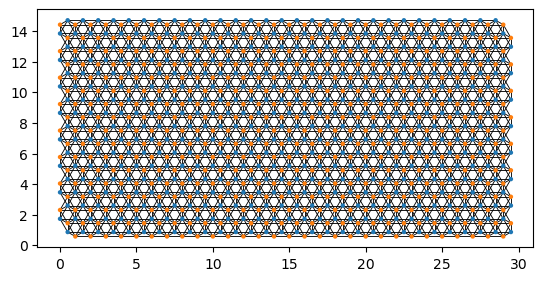

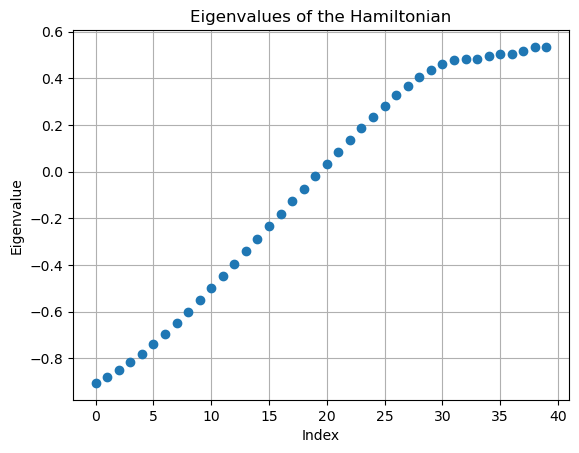

In [21]:
system_parameters = SimpleNamespace(m = 0.0, t2 = 0.15*np.exp(-1j*np.pi/3))
h = sys.finalized().hamiltonian_submatrix(sparse=False, params=dict(param=system_parameters))
N = len(h)
eigenvalues, eigenvectors = np.linalg.eigh(h)
eigenstates = eigenvectors.T
i_0 = binary_search(eigenvalues, 0.0)
kwant.plot(sys, show=False)
plt.show()
plt.plot(np.sort(eigenvalues)[i_0-40//2:i_0+40//2], 'o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Hamiltonian')
plt.grid()
plt.show()

## Bott index

In [25]:
botts = []
for m_ in np.linspace(0, 1.5, 26):
    # system_parameters = SimpleNamespace(m=m_, B=0.0, t_prime=0.0, t2=0.15*np.exp(-1j*np.pi/3))
    system_parameters = SimpleNamespace(m=m_, B=0.0, t2=-0.02j)
    h = sys.finalized().hamiltonian_submatrix(sparse=False, params=dict(param=system_parameters))
    N = len(h)
    eigenvalues, eigenvectors = np.linalg.eigh(h)
    eigenstates = eigenvectors.T
    # print("eigenvectors calculated")

    P = np.zeros([len(eigenstates[0]),len(eigenstates[0])], dtype=complex)
    # N_occ = binary_search(eigenvalues, 0.0)
    N_occ = N//2
    for i in range(N_occ):
        P += np.array([eigenstates[i]]).T@np.array([eigenstates[i].conj()])

    # print("Fermi projector calculated")
    x_positions = np.array([s.pos[0] for s in sys.finalized().sites])
    x_norm = (x_positions-min(x_positions))/(max(x_positions)-min(x_positions))
    y_positions = np.array([s.pos[1] for s in sys.finalized().sites])
    y_norm = (y_positions-min(y_positions))/(max(y_positions)-min(y_positions))

    X = np.diag(x_norm)
    # X = np.diag(x_positions - min(x_positions))
    Y = np.diag(y_norm)
    # Y = np.diag(y_positions - min(y_positions))
    pXp = P@X@P
    pYp = P@Y@P
    # print("X and Y projections calculated")

    U = la.expm(1j*2*np.pi*pXp)
    V = la.expm(1j*2*np.pi*pYp)
    # print("U and V calculated")
    
    UVUdVd = U@V@np.conj(U.T)@np.conj(V.T)
    bott = np.imag(np.sum(np.log(np.linalg.eigvals(UVUdVd))))/2/np.pi
    botts.append(bott)
    # bott = 2*np.pi*1j*np.trace(pXp@pYp - pYp@pXp)
    print("m", m_, ", Bott index:", bott)

m 0.0 , Bott index: 1.0000000000000029
m 0.06 , Bott index: 0.9999999999999959
m 0.12 , Bott index: -2.1264396819235458e-15


KeyboardInterrupt: 

In [158]:
while len(botts) < 26:
    botts.append(5e-16*np.random.randn())

In [159]:
print("Bott indices: [1., 1., 1., 1, 1, -2.17e-15, -3.85e-15, 6.51e-16, -1.11e-14, -3.58e-15, -5.69e-15, -8.83e-15, -1.57e-14, -5.77e-15, -1.21e-15, -5.55e-15, -2.75e-15, -5.26e-15, -5.29e-15, -6.65e-15, 2.57e-15, 1.06e-15, 5.03e-16, 5.32e-15, -1.34e-15, -3.958e-15] ", "\nmass:", np.linspace(0, 1.5, 26), "\nparameters:", "t2=(0.075-0.1299j", "shape: hexagon zigzag", f"Lx= 15")
print("Bott indices: [1., 1., 1., 1, 1,  1., 1., -3.41e-15, -8.35e-15, 5.76e-16, 2.82e-15, 2.00e-15, -1.34e-14, -7.75e-16, -1.83e-15,  1.17e-16,  7.13e-16, -9.11e-15, -1.98e-15,  5.21e-16, 4.95e-15, -3.15e-15, -3.19e-15, -4.54e-16, -1.14e-14, -3.37e-15]", "\nmass:", np.linspace(0, 1.5, 26), "\nparameters:", "t2=(0.075-0.1299j", "shape: hexagon zigzag", f"Lx= 18")
print("Bott indices: [1., 1., 1., 1.,1., 1., 1., -6.808e-15, -2.80e-15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]", "\nmass:", np.linspace(0, 1.5, 26), "\nparameters:", "t2=(0.075-0.1299j", "shape: hexagon zigzag", f"Lx= 21")
print("Bott indices: Bott indices: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.0, 0, 0, 0, 0, 0, ...] ", "\nmass:", np.linspace(0, 1.5, 26), "\nparameters:", "t2=(0.075-0.1299j", "shape: hexagon zigzag", f"Lx= 25")
# hex -zz Lx= 2: 15
# hex -zz Lx= 3: 9
# hex -zz Lx= 4: 7
# hex -zz Lx= 5: 7
# hex -zz Lx= 7: 7
# hex -zz Lx= 8: 8
# hex -zz Lx= 9: 8
# hex -zz Lx=10: 8
# hex -zz Lx=12: 8
# hex -zz Lx=15: 8
# hex -zz Lx=20: 8

# circle radius 02: 2
# circle radius 03: 0
# circle radius 04: 9
# circle radius 05: 7
# circle radius 06: 8
# circle radius 07: 8
# circle radius 08: 8
# circle radius 09: 8
# circle radius 10: 8
# circle radius 15: 8
# circle radius 20: 8
# circle radius 22: 8

# tri -zz Lx= 20: 

print("Bott indices:", list(np.round(botts, 3)), "\nmass:", np.linspace(0, 1.5, 26), "\nparameters:", system_parameters, "shape: Circle", f"Lx={Lx}")

Bott indices: [1., 1., 1., 1, 1, -2.17e-15, -3.85e-15, 6.51e-16, -1.11e-14, -3.58e-15, -5.69e-15, -8.83e-15, -1.57e-14, -5.77e-15, -1.21e-15, -5.55e-15, -2.75e-15, -5.26e-15, -5.29e-15, -6.65e-15, 2.57e-15, 1.06e-15, 5.03e-16, 5.32e-15, -1.34e-15, -3.958e-15]  
mass: [0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.78
 0.84 0.9  0.96 1.02 1.08 1.14 1.2  1.26 1.32 1.38 1.44 1.5 ] 
parameters: t2=(0.075-0.1299j shape: hexagon zigzag Lx= 15
Bott indices: [1., 1., 1., 1, 1,  1., 1., -3.41e-15, -8.35e-15, 5.76e-16, 2.82e-15, 2.00e-15, -1.34e-14, -7.75e-16, -1.83e-15,  1.17e-16,  7.13e-16, -9.11e-15, -1.98e-15,  5.21e-16, 4.95e-15, -3.15e-15, -3.19e-15, -4.54e-16, -1.14e-14, -3.37e-15] 
mass: [0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.78
 0.84 0.9  0.96 1.02 1.08 1.14 1.2  1.26 1.32 1.38 1.44 1.5 ] 
parameters: t2=(0.075-0.1299j shape: hexagon zigzag Lx= 18
Bott indices: [1., 1., 1., 1.,1., 1., 1., -6.808e-15, -2.80e-15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

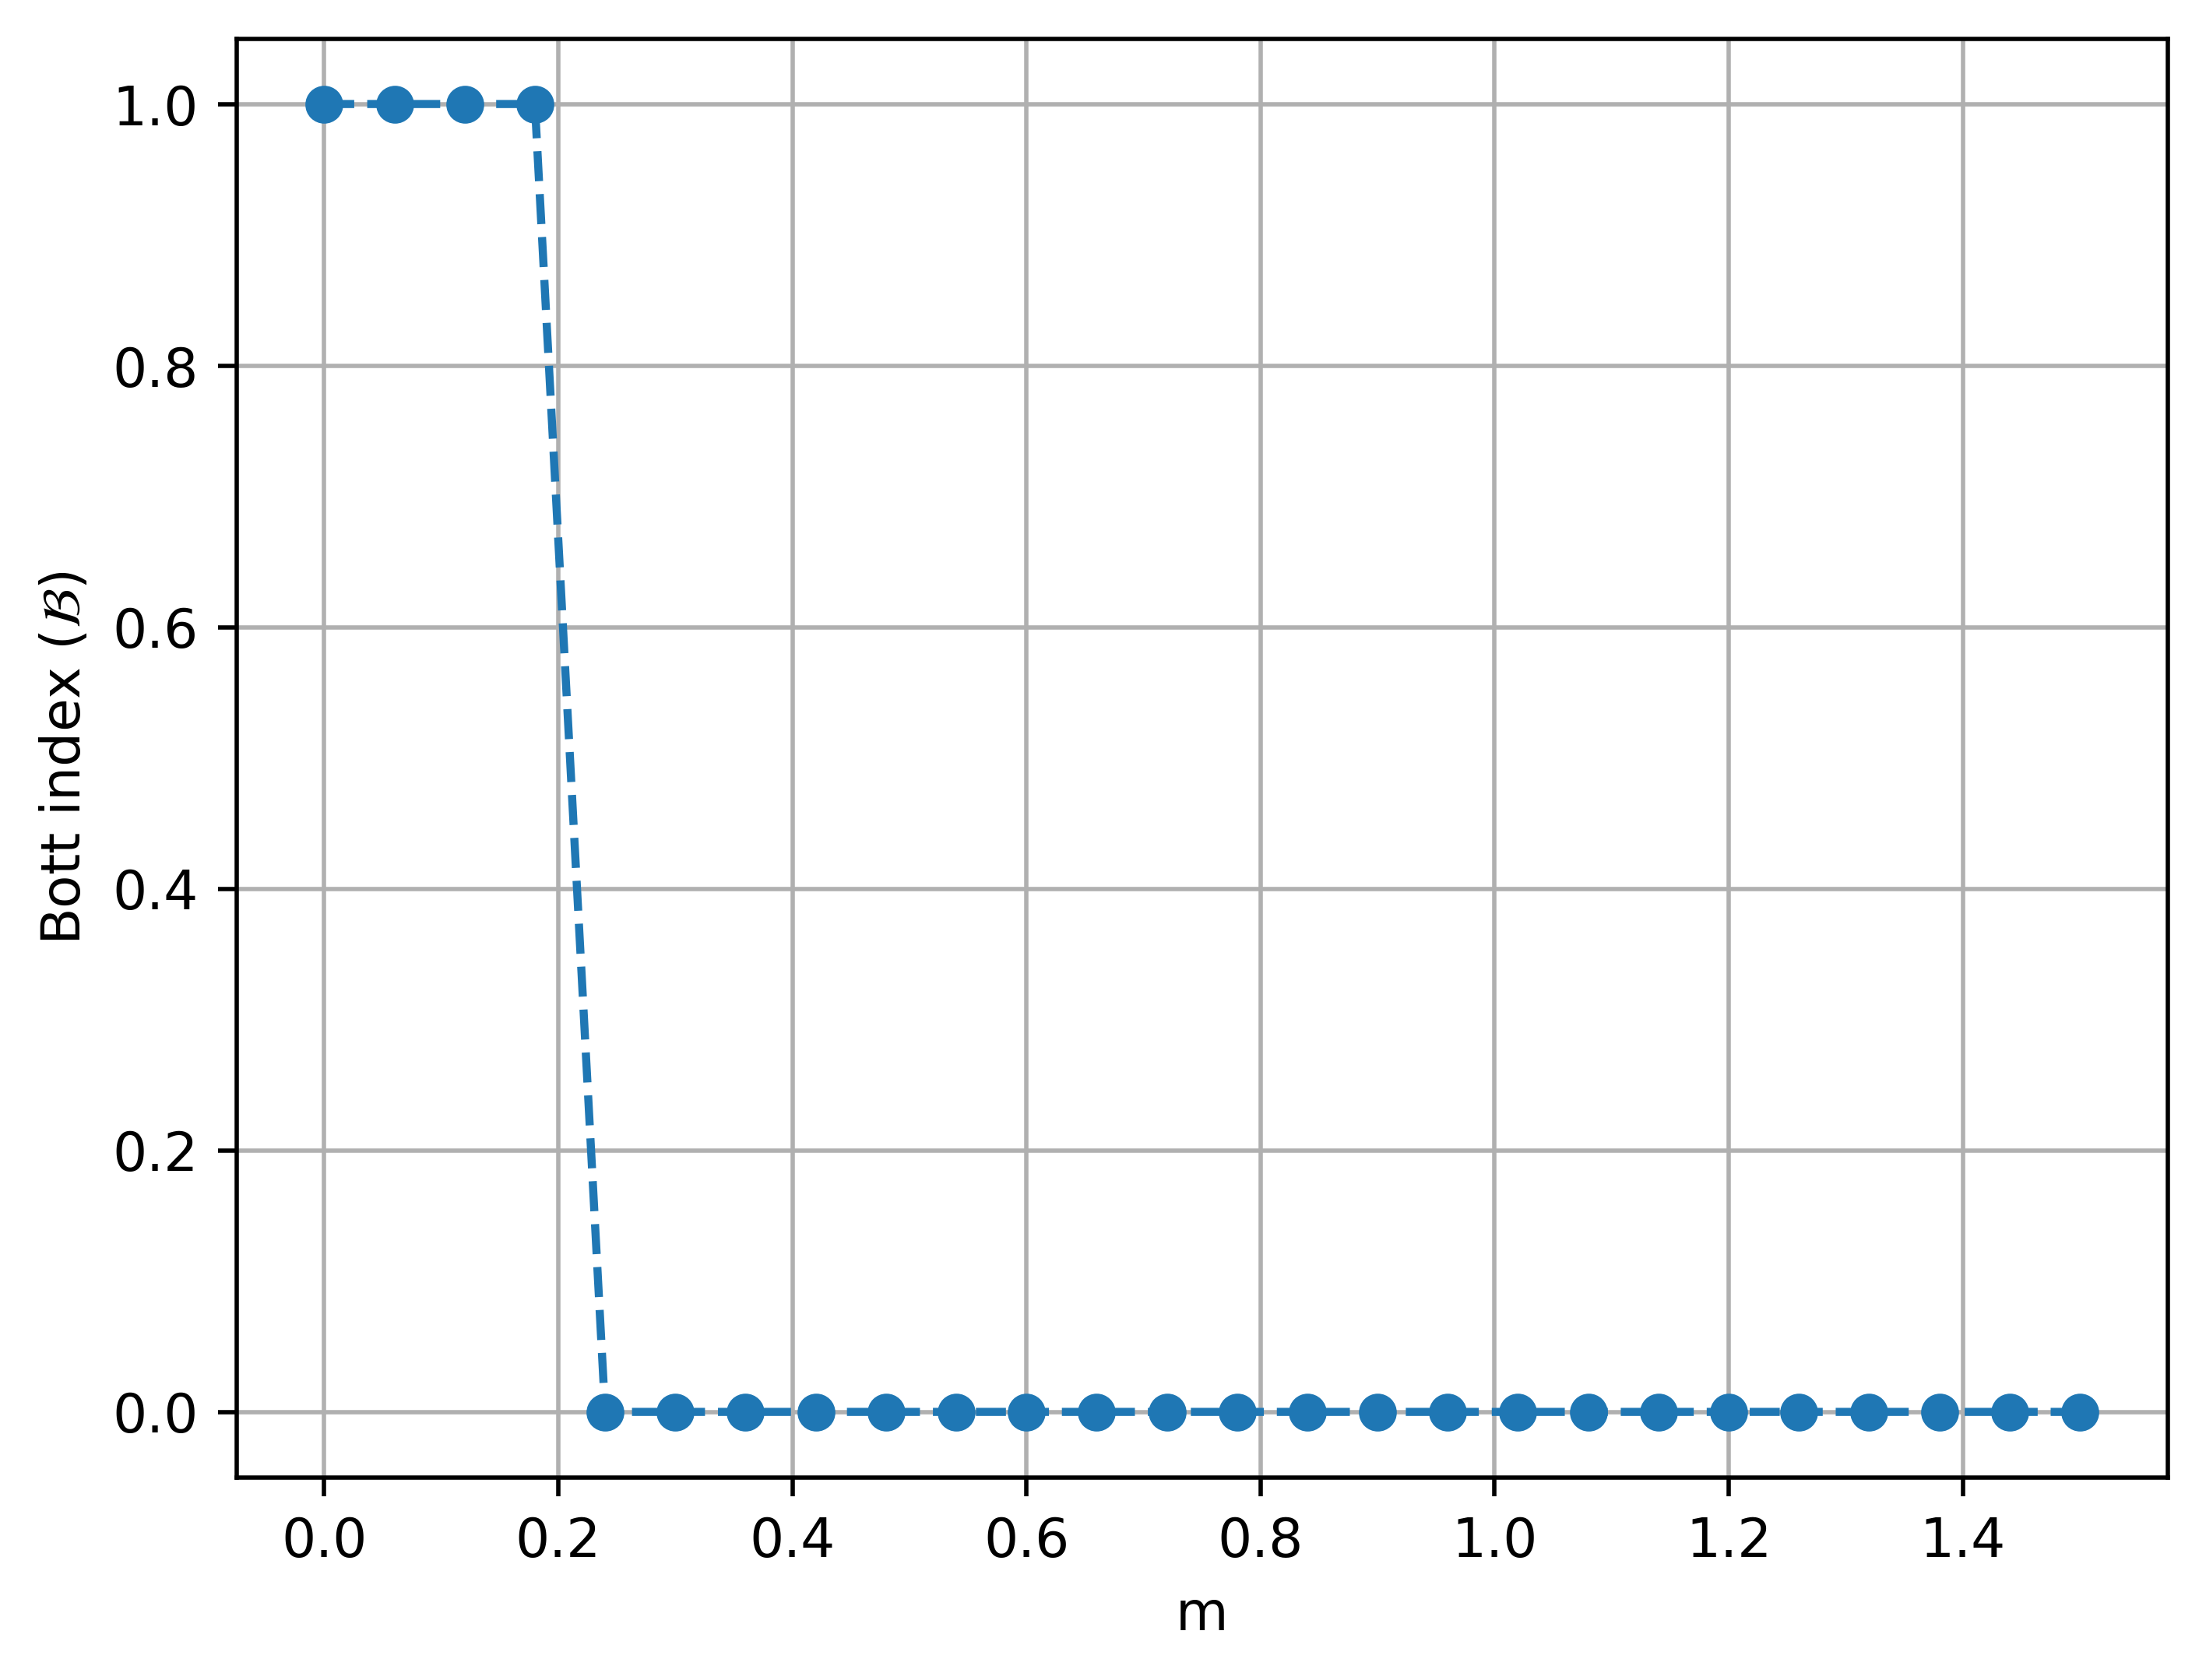

In [160]:
plt.figure(dpi=500)
plt.plot(np.linspace(0, 1.5, 26), botts, 'o--')
plt.xlabel('m')
plt.ylabel(r'Bott index ($\mathbf{\mathcal{B}}$)')
# plt.title('Bott index vs m')
plt.grid()
plt.savefig(f'bott_index_vs_m-rectangle-{Lx}x{Ly}.png')
plt.show()

In [161]:
dictionary[f"rect-{Lx}x{Ly}"] = np.array(botts)

In [ ]:
print(dictionary)
"""
{'rect-40x30': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00, -1.21888794e-14,
        2.86938747e-15, -2.19086158e-14,  2.67974571e-15,  3.26701849e-16,
        7.31748131e-15, -9.69517606e-15, -2.25873516e-16,  1.99453733e-15,
        9.66298843e-17, -1.80152983e-15, -5.72117024e-15,  7.28624235e-15,
        1.78283062e-15,  1.52785328e-14]), 'rect-35x30': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -8.21917568e-15, -1.80608703e-16,
        3.66443619e-16,  8.52743556e-16, -1.13194120e-15, -8.27946803e-16,
       -2.57107947e-16,  1.87253801e-16, -3.00122372e-16, -2.77216959e-16,
       -3.32946274e-16,  4.94015171e-16,  1.38841745e-16, -1.46746438e-16,
       -1.79343733e-16, -2.15153346e-16]), 'rect-30x30': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -4.04697318e-15,  2.92159931e-15,
        7.00112377e-16,  8.35254084e-15, -5.25460119e-16, -6.41968170e-15,
       -5.71571401e-15, -5.90114093e-16,  3.76062579e-15, -1.28471767e-15,
        5.11718766e-16,  9.56218095e-15,  4.85945553e-15,  4.34988612e-15,
        1.60590962e-15, -2.74016187e-15]), 'rect-30x20': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  7.76607123e-15, -1.52058262e-15,
       -6.25124473e-15, -8.07927973e-16,  3.98193443e-16, -5.96607821e-16,
        2.93981480e-15,  1.89297691e-15, -7.68400635e-15, -3.13798784e-15,
       -2.60280114e-15, -3.19843859e-15,  1.63961357e-15, -3.34015665e-15,
       -6.31019681e-15, -3.28526984e-16]), 'rect-25x20': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -8.44502000e-15, -2.72530767e-15,
        1.44297385e-15, -1.52402298e-15, -4.60024284e-15, -3.22411410e-15,
        1.82251260e-15, -3.90675766e-16, -7.77886852e-15, -1.99752768e-17,
        4.40907085e-15, -7.23902312e-15,  1.62586615e-15,  4.79591693e-15,
        2.83465386e-15, -1.96739908e-15]), 'rect-25x15': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -2.60407167e-15, -6.38413372e-15,
        1.06200453e-16, -5.36970848e-15, -3.60216000e-15,  3.95573388e-15,
        3.60779026e-15,  9.29379673e-16,  4.09979121e-15,  9.15913334e-16,
        5.95342335e-16, -2.09205888e-15,  4.27775043e-15,  3.84584921e-15,
       -8.68345733e-15,  3.53976954e-15]), 'rect-20x15': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00, -3.32501315e-16,  3.11398918e-15,  2.12396672e-15,
        1.11400872e-15, -5.31841430e-15, -3.52354219e-16,  8.42799585e-16,
       -1.40132160e-15,  1.09769954e-15,  1.19643744e-15,  1.41047607e-15,
        2.16970905e-15, -3.14232994e-15, -1.73775352e-16,  2.17190555e-15,
        4.69697554e-15, -7.02710257e-16]), 'rect-15x15': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00, -6.78661358e-16, -2.28315010e-15, -7.92137339e-16,
        1.91386984e-15, -2.49452167e-15, -1.74456106e-16, -1.93987178e-15,
        2.78456167e-15, -2.25039913e-15,  2.79287672e-15,  4.44241308e-15,
       -5.85203405e-16, -3.00878553e-15,  2.82329716e-15, -1.18858526e-15,
       -2.58552451e-16,  6.36394778e-16]), 'rect-15x10': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  6.89096546e-16,  1.08133546e-15, -8.40431690e-16,
        2.71294654e-15, -2.49433230e-15,  1.62231475e-15,  4.16216295e-15,
       -1.39506431e-15, -2.60702641e-15, -3.70121629e-16, -2.89232791e-15,
        2.06825430e-15, -1.43242259e-15, -5.26670473e-15, -6.37538623e-16,
        5.01303181e-15,  1.56147477e-15]), 'rect-10x10': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.26720150e-15, -3.26054092e-15,  1.50725189e-16,  8.54436643e-17,
       -4.49243831e-16, -1.70725422e-15,  7.63107702e-16,  1.36557515e-15,
        1.98136504e-16,  1.77715114e-15, -2.58864912e-15, -2.67319516e-15,
        7.30131247e-16, -6.16405948e-16,  2.48819826e-15,  3.22542629e-15,
       -7.16618956e-16,  1.14246249e-16]), 'rect-10x7': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  2.10880853e-15,
       -9.14193776e-16, -1.64171632e-15, -1.33638256e-16,  2.00270807e-15,
        5.00041796e-16,  9.52335152e-16, -1.16704028e-15,  1.01657996e-15,
       -1.16628103e-15, -1.44193946e-15,  8.73276402e-16, -1.10405729e-16,
       -1.19361824e-15,  4.62079446e-16,  2.35987986e-15, -1.57842220e-16,
       -3.95835146e-16, -2.17681236e-15]), 'rect-10x5': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  3.30824622e-16,  5.94037437e-16,
        3.21370703e-16, -1.11650722e-15,  2.44089281e-16,  5.06642068e-16,
        2.33813563e-16, -4.57920843e-16, -8.51072742e-16,  1.46339466e-16,
        2.79476230e-17,  6.72641070e-16, -4.08742345e-18, -6.12459961e-16,
        6.89508432e-16, -1.08940512e-15, -8.00198879e-16,  3.71068926e-16,
       -3.77393209e-16, -2.47738843e-16]), 'rect-7x5': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -8.46905511e-17,  4.61415105e-16,
       -6.15818335e-16,  5.09661801e-16,  4.66453744e-16,  2.60697809e-16,
       -1.32364360e-15, -7.24218099e-16,  9.00639491e-16, -2.11847167e-16,
       -6.22444490e-16,  1.18960200e-16,  6.98231145e-16,  1.32143488e-15,
       -2.67462009e-16,  6.98438212e-16,  6.22789603e-16, -5.15149086e-16,
       -6.98239773e-16, -1.23596783e-15]), 'rect-7x3': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
       -1.41357986e-16, -7.06789929e-17, -2.12036979e-16,  3.53394965e-16,
        1.06018489e-16,  3.18055468e-16,  4.94752950e-16, -1.06018489e-16,
       -2.82715972e-16, -1.76697482e-17, -3.53394965e-16,  3.35725216e-16,
       -3.53394965e-16,  5.30092447e-16, -2.65046223e-16, -3.35725216e-16,
       -3.18055468e-16, -4.24073958e-16, -7.73051485e-17,  9.60792560e-17,
        4.94752950e-16, -4.63830891e-17]), 'rect-5x3': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        2.82715972e-16, -7.06789929e-17, -7.06789929e-17,  1.41357986e-16,
        2.82715972e-16, -4.24073958e-16,  2.47376475e-16, -4.24073958e-16,
       -1.41357986e-16,  3.53394965e-17,  1.76697482e-16, -5.12422699e-16,
       -1.59027734e-16, -1.06018489e-16, -6.00771440e-16, -3.00385720e-16,
       -8.83487412e-17,  4.41743706e-16,  3.18055468e-16,  1.67862608e-16,
        1.76697482e-17,  1.76697482e-16])}
"""
pass

{'rect-40x30': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00, -1.21888794e-14,
        2.86938747e-15, -2.19086158e-14,  2.67974571e-15,  3.26701849e-16,
        7.31748131e-15, -9.69517606e-15, -2.25873516e-16,  1.99453733e-15,
        9.66298843e-17, -1.80152983e-15, -5.72117024e-15,  7.28624235e-15,
        1.78283062e-15,  1.52785328e-14]), 'rect-35x30': array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -8.21917568e-15, -1.80608703e-16,
        3.66443619e-16,  8.52743556e-16, -1.13194120e-15, -8.27946803e-16,
       -2.57107947e-16,  1.87253801e-16, -3.00122372e-16, -2.77216959e-16,
       -3.32946274e-16,  4.94015171e-16,  1.38841745e-16, -1.46746438e-16,
       -1.79343733e-16, -2.1

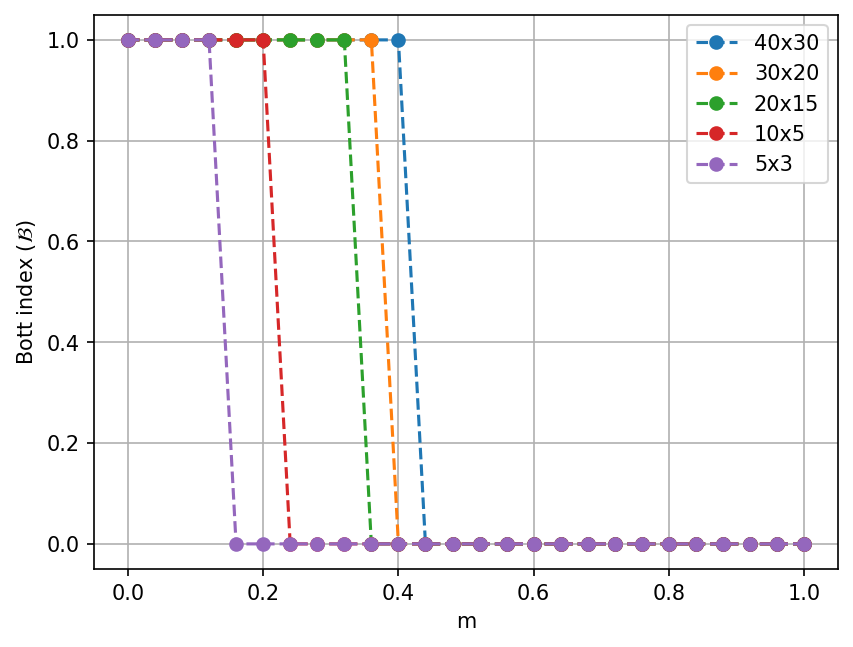

In [169]:
plt.figure(dpi=150)
m_values = np.linspace(0, 1, 26)
for key in ["rect-40x30", "rect-30x20", "rect-20x15", "rect-10x5", "rect-5x3"]:
    if key in dictionary:
        plt.plot(m_values, dictionary[key], 'o--', label=key.split("-")[1])
plt.xlabel('m')
plt.ylabel(r'Bott index ($\mathcal{B}$)')
plt.legend()
plt.grid()
plt.savefig('bott_index_vs_m_sizes_rectangles.png')
plt.show()